In [13]:
!git clone https://github.com/AhmedSheded/self-driving-car.git

Cloning into 'self-driving-car'...
remote: Enumerating objects: 15755, done.
remote: Total 15755 (delta 0), reused 0 (delta 0), pack-reused 15755
Receiving objects: 100% (15755/15755), 246.89 MiB | 34.96 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (15600/15600), done.


In [14]:
!ls self-driving-car

data  finding-lanes  sections


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras 
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Convolution2D, MaxPool2D, Flatten, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import random
import os
import ntpath
random.seed(2222)

In [17]:
datadir = 'self-driving-car/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,/home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_095.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_095.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_095.jpg,0.0,0.0,0.0,0.000051
1,/home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_212.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_212.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_212.jpg,0.0,0.0,0.0,0.000050
2,/home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_334.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_334.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_334.jpg,0.0,0.0,0.0,0.000050
3,/home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_453.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_453.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_453.jpg,0.0,0.0,0.0,0.000050
4,/home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_574.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_574.jpg,/home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_574.jpg,0.0,0.0,0.0,0.000050


In [19]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [20]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_09_07_01_51_32_095.jpg,left_2022_09_07_01_51_32_095.jpg,right_2022_09_07_01_51_32_095.jpg,0.0,0.0,0.0,0.000051
1,center_2022_09_07_01_51_32_212.jpg,left_2022_09_07_01_51_32_212.jpg,right_2022_09_07_01_51_32_212.jpg,0.0,0.0,0.0,0.000050
2,center_2022_09_07_01_51_32_334.jpg,left_2022_09_07_01_51_32_334.jpg,right_2022_09_07_01_51_32_334.jpg,0.0,0.0,0.0,0.000050
3,center_2022_09_07_01_51_32_453.jpg,left_2022_09_07_01_51_32_453.jpg,right_2022_09_07_01_51_32_453.jpg,0.0,0.0,0.0,0.000050
4,center_2022_09_07_01_51_32_574.jpg,left_2022_09_07_01_51_32_574.jpg,right_2022_09_07_01_51_32_574.jpg,0.0,0.0,0.0,0.000050


In [21]:
data.shape

(5191, 7)

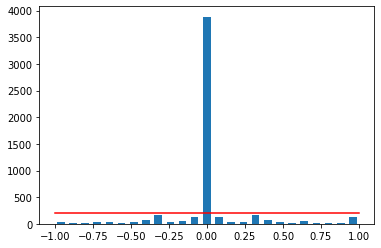

In [31]:
n_pins = 25
samples_ber_bin = 200
hist, bins = np.histogram(data['steering'],n_pins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_ber_bin, samples_ber_bin), c='r')

In [42]:
remove_list = []
for j in range(n_pins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_ber_bin:]
  remove_list.extend(list_)

print('total data ', len(data))
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace =True)
print('remaining data', len(data))

total data  5191
removed 3686
remaining data 1505


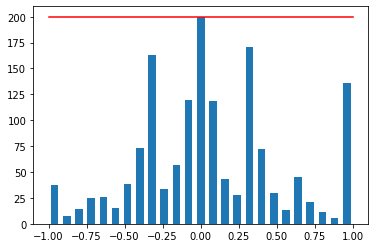

In [43]:
hist, _ = np.histogram(data['steering'], (n_pins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_ber_bin, samples_ber_bin), c='r')

In [54]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(indexed_data[3])
  image_paths = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_paths, steering

image_paths, steering = load_img_steering(datadir+'/IMG', data)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steering, test_size=0.2, random_state=2222)

In [56]:
print(f'Traning samples {len(X_train)}\nValid samples {len(X_val)}')

Traning samples 1204
Valid samples 301


Text(0.5, 1.0, 'Validation set')

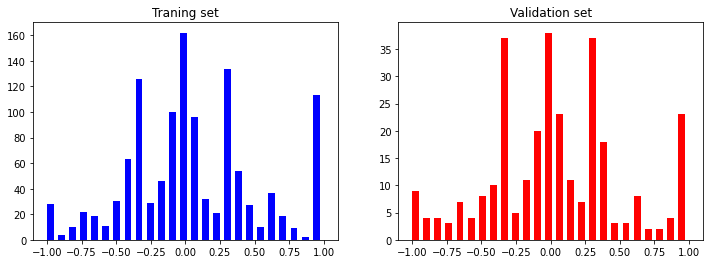

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 
ax[0].hist(y_train, bins=n_pins, width=0.05, color='b')
ax[0].set_title('Traning set')
ax[1].hist(y_val, bins=n_pins, width=0.05, color='r')
ax[1].set_title('Validation set')

In [77]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135 :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

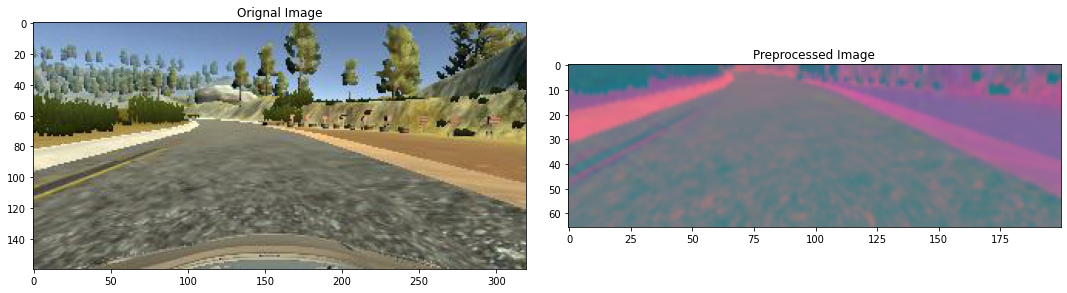

In [78]:
from sklearn import preprocessing
image = image_paths[100]
orignal_img = mpimg.imread(image)
preprocessed_img = img_preprocess(image)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
ax[0].imshow(orignal_img)
ax[0].set_title('Orignal Image')
ax[1].imshow(preprocessed_img)
ax[1].set_title('Preprocessed Image')

In [79]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

(1204, 66, 200, 3)


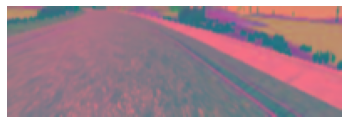

In [84]:
plt.imshow(X_train[random.randint(0, len(X_train-1))])
plt.axis('off')
print(X_train.shape)

In [117]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='relu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu')) 
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.4))

  model.add(Dense(10, activation='relu'))
  
  model.add(Dense(1))
  model.compile(loss='mse', optimizer=Adam(learning_rate=1e-3))
  return model

In [118]:
model = nvidia_model()
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_23 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_24 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_25 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_11 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_4 (Flatten)         (None, 1152)             

In [123]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=100, verbose=1, shuffle=True)

Epoch 1/10
13/13 [==============================] - 8s 583ms/step - loss: 0.0629 - val_loss: 0.0767
Epoch 2/10
13/13 [==============================] - 8s 577ms/step - loss: 0.0618 - val_loss: 0.0779
Epoch 3/10
13/13 [==============================] - 7s 575ms/step - loss: 0.0640 - val_loss: 0.0774
Epoch 4/10
13/13 [==============================] - 7s 574ms/step - loss: 0.0606 - val_loss: 0.0850
Epoch 5/10
13/13 [==============================] - 7s 576ms/step - loss: 0.0660 - val_loss: 0.0796
Epoch 6/10
13/13 [==============================] - 7s 568ms/step - loss: 0.0611 - val_loss: 0.0779
Epoch 7/10
13/13 [==============================] - 8s 577ms/step - loss: 0.0606 - val_loss: 0.0752
Epoch 8/10
13/13 [==============================] - 7s 571ms/step - loss: 0.0613 - val_loss: 0.0744
Epoch 9/10
13/13 [==============================] - 7s 569ms/step - loss: 0.0601 - val_loss: 0.0791
Epoch 10/10
13/13 [==============================] - 7s 566ms/step - loss: 0.0581 - val_loss: 0.0727

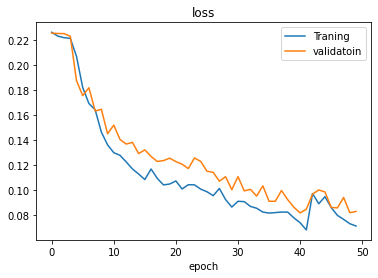

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Traning', 'validatoin'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

In [124]:
model.save('model.h5')